In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import json
from os import listdir
from os.path import isfile, join
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM,Dropout
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from tensorflow.python.client import device_lib
import tensorflow as tf
import re
nltk.download("averaged_perceptron_tagger")
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Mounted at /content/drive


In [87]:
data = pd.read_json('/content/drive/My Drive/Sarcasm_Headlines_Dataset.json', lines=True, orient='columns', encoding='utf-8')

In [88]:
data.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


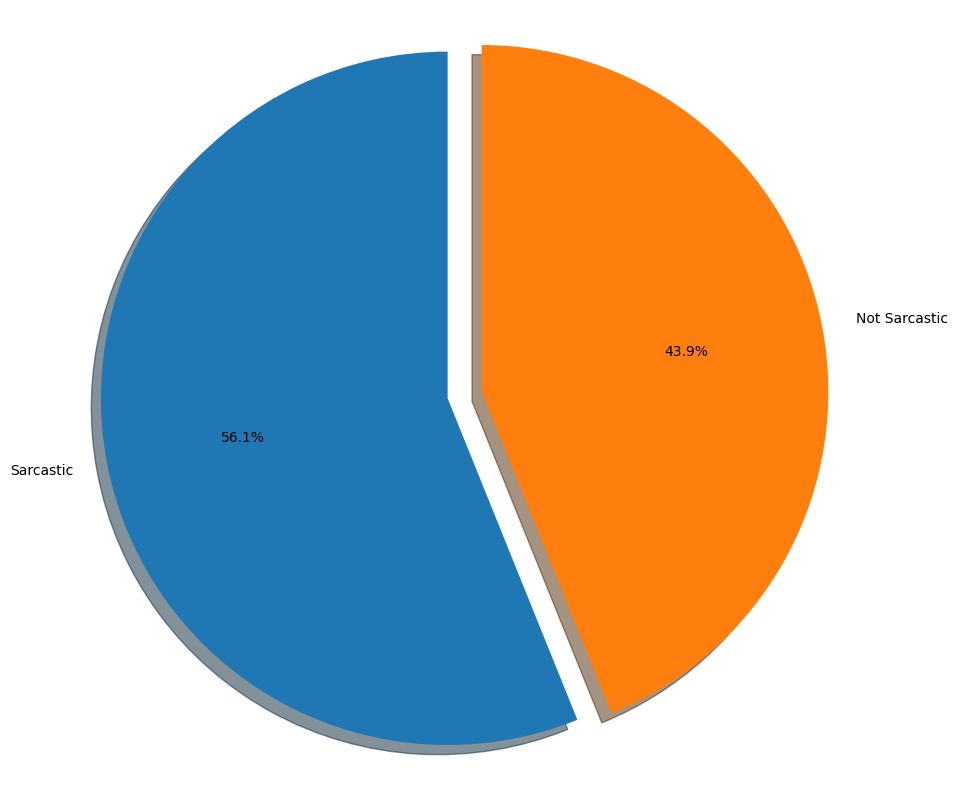

In [11]:
labels = ['Sarcastic', 'Not Sarcastic']

zeros_percent = (data['is_sarcastic'].value_counts()[0]/ data['is_sarcastic'].value_counts().sum())*100
ones_percent = (data['is_sarcastic'].value_counts()[1]/ data['is_sarcastic'].value_counts().sum())*100

sizes = [zeros_percent,ones_percent]
explode = (0, 0.1)
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels, explode = explode,
        autopct='%1.1f%%', shadow=True, startangle= 90, pctdistance=0.6)
plt.axis('equal')
plt.show()

Check for missing values

In [12]:
print(data.isnull().sum())

article_link    0
headline        0
is_sarcastic    0
dtype: int64


Drop article_link table

In [13]:
data = data.drop(['article_link'], axis=1)
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Calculating the length of the sentences

In [14]:
data['len'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [15]:
data['len'].max()

39

In [16]:
pd.options.display.max_colwidth = 300
data[data['len']==39]

,headline,is_sarcastic,len
15247,"elmore leonard, modern prose master, noted for his terse prose style and for writing about things perfectly and succinctly with a remarkable economy of words, unfortunately and sadly expired this gloomy tuesday at the age of 87 years old",1,39


In [17]:
for i,headline in enumerate (data['headline'], 1):
    if i > 20:
        break
    else:
        print(i, headline)

1 former versace store clerk sues over secret 'black code' for minority shoppers
2 the 'roseanne' revival catches up to our thorny political mood, for better and worse
3 mom starting to fear son's web series closest thing she will have to grandchild
4 boehner just wants wife to listen, not come up with alternative debt-reduction ideas
5 j.k. rowling wishes snape happy birthday in the most magical way
6 advancing the world's women
7 the fascinating case for eating lab-grown meat
8 this ceo will send your kids to school, if you work for his company
9 top snake handler leaves sinking huckabee campaign
10 friday's morning email: inside trump's presser for the ages
11 airline passengers tackle man who rushes cockpit in bomb threat
12 facebook reportedly working on healthcare features and apps
13 north korea praises trump and urges us voters to reject 'dull hillary'
14 actually, cnn's jeffrey lord has been 'indefensible' for a while
15 barcelona holds huge protest in support of refugees
16 n

In [20]:
data_length = data['len'].value_counts().reset_index()
data_length.rename(columns={'index': 'length_word', 'len':'frequency'}, inplace = True)
data_length.head()

,frequency,count
0,10,3484
1,9,3300
2,11,3196
3,8,2857
4,12,2646


<BarContainer object of 32 artists>

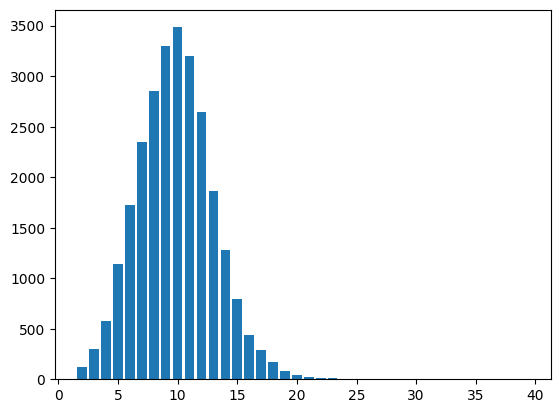

In [22]:
import matplotlib.pyplot as plt
plt.bar(data_length['frequency'], data_length['count'])

In [23]:
def clean_data(x):
  return re.sub('[^A-Za-z ]+', '', x)


data['clean_hd'] = data["headline"].apply(clean_data)

In [24]:
data.to_csv("/content/drive/My Drive/new_data.csv")

In [25]:
data.head()

,headline,is_sarcastic,len,clean_hd
0,former versace store clerk sues over secret 'black code' for minority shoppers,0,12,former versace store clerk sues over secret black code for minority shoppers
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,14,the roseanne revival catches up to our thorny political mood for better and worse
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas
4,j.k. rowling wishes snape happy birthday in the most magical way,0,11,jk rowling wishes snape happy birthday in the most magical way


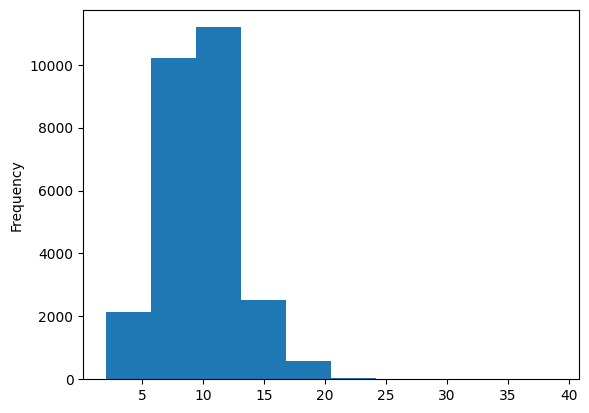

In [26]:
data['len'].plot(kind='hist')
plt.show()

In [27]:
# removing those headline whose length is greather than 15
print('shape before preprocessing ',data.shape)
data = data[data['len'] < 20]
print('shape after preprocessing ',data.shape)
data.head()

shape before preprocessing  (26709, 4)
shape after preprocessing  (26606, 4)


,headline,is_sarcastic,len,clean_hd
0,former versace store clerk sues over secret 'black code' for minority shoppers,0,12,former versace store clerk sues over secret black code for minority shoppers
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,14,the roseanne revival catches up to our thorny political mood for better and worse
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas
4,j.k. rowling wishes snape happy birthday in the most magical way,0,11,jk rowling wishes snape happy birthday in the most magical way


In [28]:
# Tokenization process
def tokenize_data(x):
  return x.split(" ")

data["tokens"] = data["clean_hd"].apply(tokenize_data)
data.head()

,headline,is_sarcastic,len,clean_hd,tokens
0,former versace store clerk sues over secret 'black code' for minority shoppers,0,12,former versace store clerk sues over secret black code for minority shoppers,"[former, versace, store, clerk, sues, over, secret, black, code, for, minority, shoppers]"
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,14,the roseanne revival catches up to our thorny political mood for better and worse,"[the, roseanne, revival, catches, up, to, our, thorny, political, mood, for, better, and, worse]"
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild,"[mom, starting, to, fear, sons, web, series, closest, thing, she, will, have, to, grandchild]"
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas,"[boehner, just, wants, wife, to, listen, not, come, up, with, alternative, debtreduction, ideas]"
4,j.k. rowling wishes snape happy birthday in the most magical way,0,11,jk rowling wishes snape happy birthday in the most magical way,"[jk, rowling, wishes, snape, happy, birthday, in, the, most, magical, way]"


In [29]:
#lambda to POS tag the whole sentence

def calc_pos(x):
  tokens = x.split(" ")
  try:
    tagged_sent = nltk.pos_tag(tokens)
  except:
    tagged_sent = ["Can not Pos"]

  return tagged_sent


In [30]:
#seperating out sarcastic and non-sarcastic sentences

data_sar = data[data["is_sarcastic"] == 1]
data_non_sar = data[data["is_sarcastic"]==0]

In [31]:
#applying lambda to generate POS for both frames
data_sar["pos"] = data_sar["clean_hd"].apply(calc_pos)
data_non_sar["pos"] = data_non_sar["clean_hd"].apply(calc_pos)

<ipython-input-31-aedbecb53757>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sar["pos"] = data_sar["clean_hd"].apply(calc_pos)
<ipython-input-31-aedbecb53757>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_non_sar["pos"] = data_non_sar["clean_hd"].apply(calc_pos)


In [36]:
sarc_count ={}
non_sarc_count = {}
def pos_dict(x):
    try:
      pos_dict = dict(x)
    except:
      pos_dict = {}
    for k,v in pos_dict.items():
      if v in sarc_count:
        sarc_count[v]+=1
      else:
        sarc_count[v] = 1

    return pos_dict

def pos_dict_no_sarc(x):
    try:
      pos_dict = dict(x)
    except:
      pos_dict = {}
    for k,v in pos_dict.items():
      if v in non_sarc_count:
        non_sarc_count[v]+=1
      else:
        non_sarc_count[v] = 1

    return pos_dict


d1 = data_sar["pos"].apply(pos_dict)
d2 = data_non_sar["pos"].apply(pos_dict_no_sarc)

In [37]:
type(data_sar["pos"])

pandas.core.series.Series

In [38]:
data_sar.head()

,headline,is_sarcastic,len,clean_hd,tokens,pos
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild,"[mom, starting, to, fear, sons, web, series, closest, thing, she, will, have, to, grandchild]","[(mom, NN), (starting, VBG), (to, TO), (fear, VB), (sons, NNS), (web, JJ), (series, NN), (closest, JJS), (thing, NN), (she, PRP), (will, MD), (have, VB), (to, TO), (grandchild, VB)]"
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas,"[boehner, just, wants, wife, to, listen, not, come, up, with, alternative, debtreduction, ideas]","[(boehner, NN), (just, RB), (wants, VBZ), (wife, NN), (to, TO), (listen, VB), (not, RB), (come, VBN), (up, RP), (with, IN), (alternative, JJ), (debtreduction, NN), (ideas, NNS)]"
8,top snake handler leaves sinking huckabee campaign,1,7,top snake handler leaves sinking huckabee campaign,"[top, snake, handler, leaves, sinking, huckabee, campaign]","[(top, JJ), (snake, NN), (handler, NN), (leaves, VBZ), (sinking, VBG), (huckabee, NN), (campaign, NN)]"
15,nuclear bomb detonates during rehearsal for 'spider-man' musical,1,8,nuclear bomb detonates during rehearsal for spiderman musical,"[nuclear, bomb, detonates, during, rehearsal, for, spiderman, musical]","[(nuclear, JJ), (bomb, NN), (detonates, NNS), (during, IN), (rehearsal, NN), (for, IN), (spiderman, JJ), (musical, JJ)]"
16,cosby lawyer asks why accusers didn't come forward to be smeared by legal team years ago,1,16,cosby lawyer asks why accusers didnt come forward to be smeared by legal team years ago,"[cosby, lawyer, asks, why, accusers, didnt, come, forward, to, be, smeared, by, legal, team, years, ago]","[(cosby, NN), (lawyer, NN), (asks, VBZ), (why, WRB), (accusers, NNS), (didnt, VBP), (come, VB), (forward, NN), (to, TO), (be, VB), (smeared, VBN), (by, IN), (legal, JJ), (team, NN), (years, NNS), (ago, RB)]"


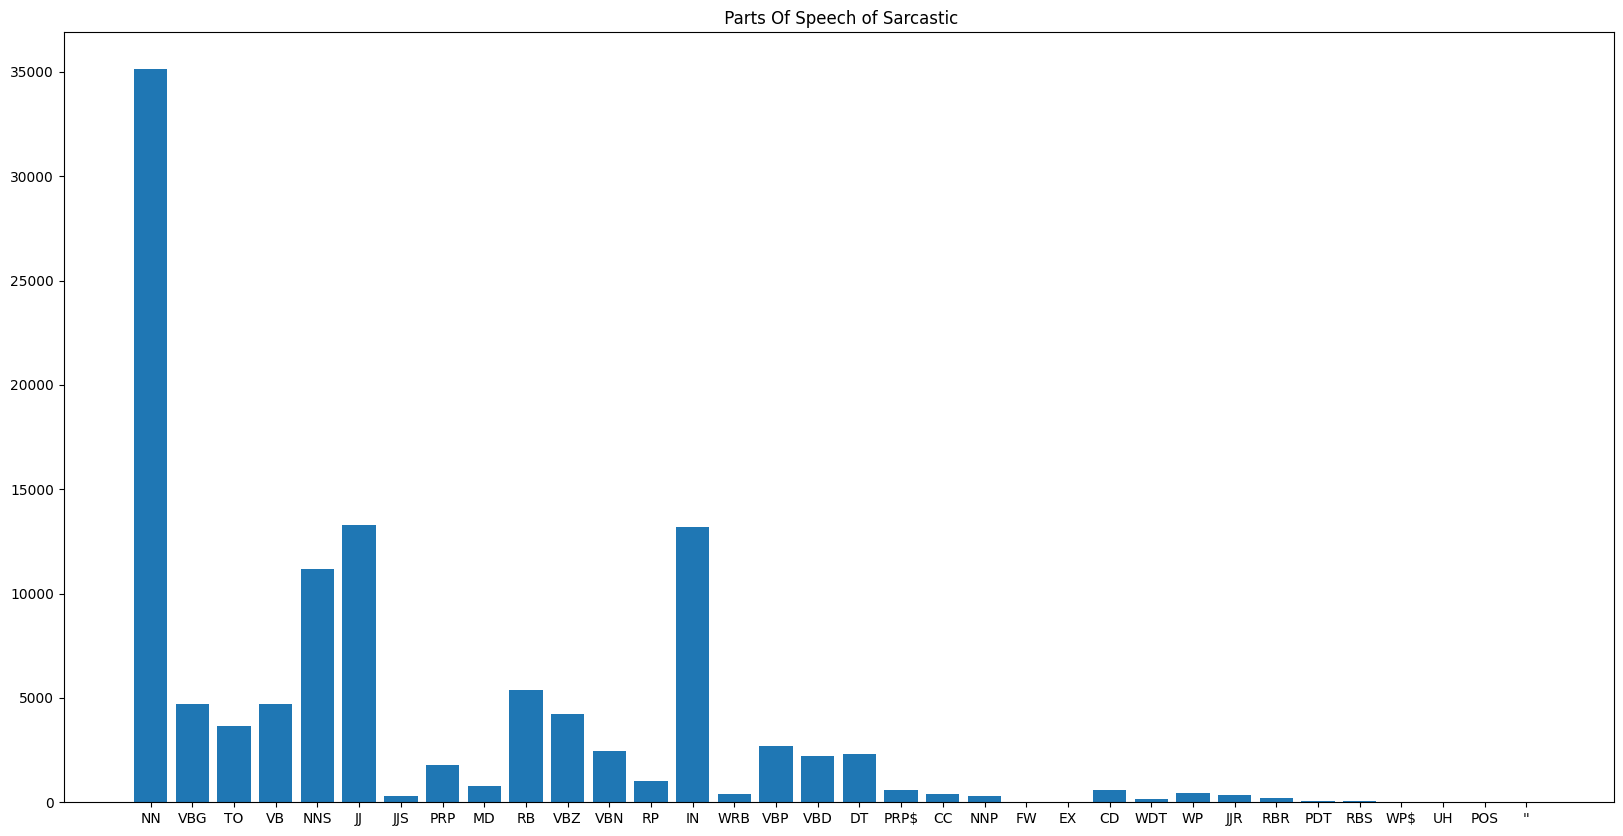

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.bar(range(len(sarc_count)), list(sarc_count.values()), align='center')
plt.xticks(range(len(sarc_count)), list(sarc_count.keys()))

# plt.bar(*zip(*sarc_count.items()), align = 'center')
plt.title(" Parts Of Speech of Sarcastic")
plt.show()



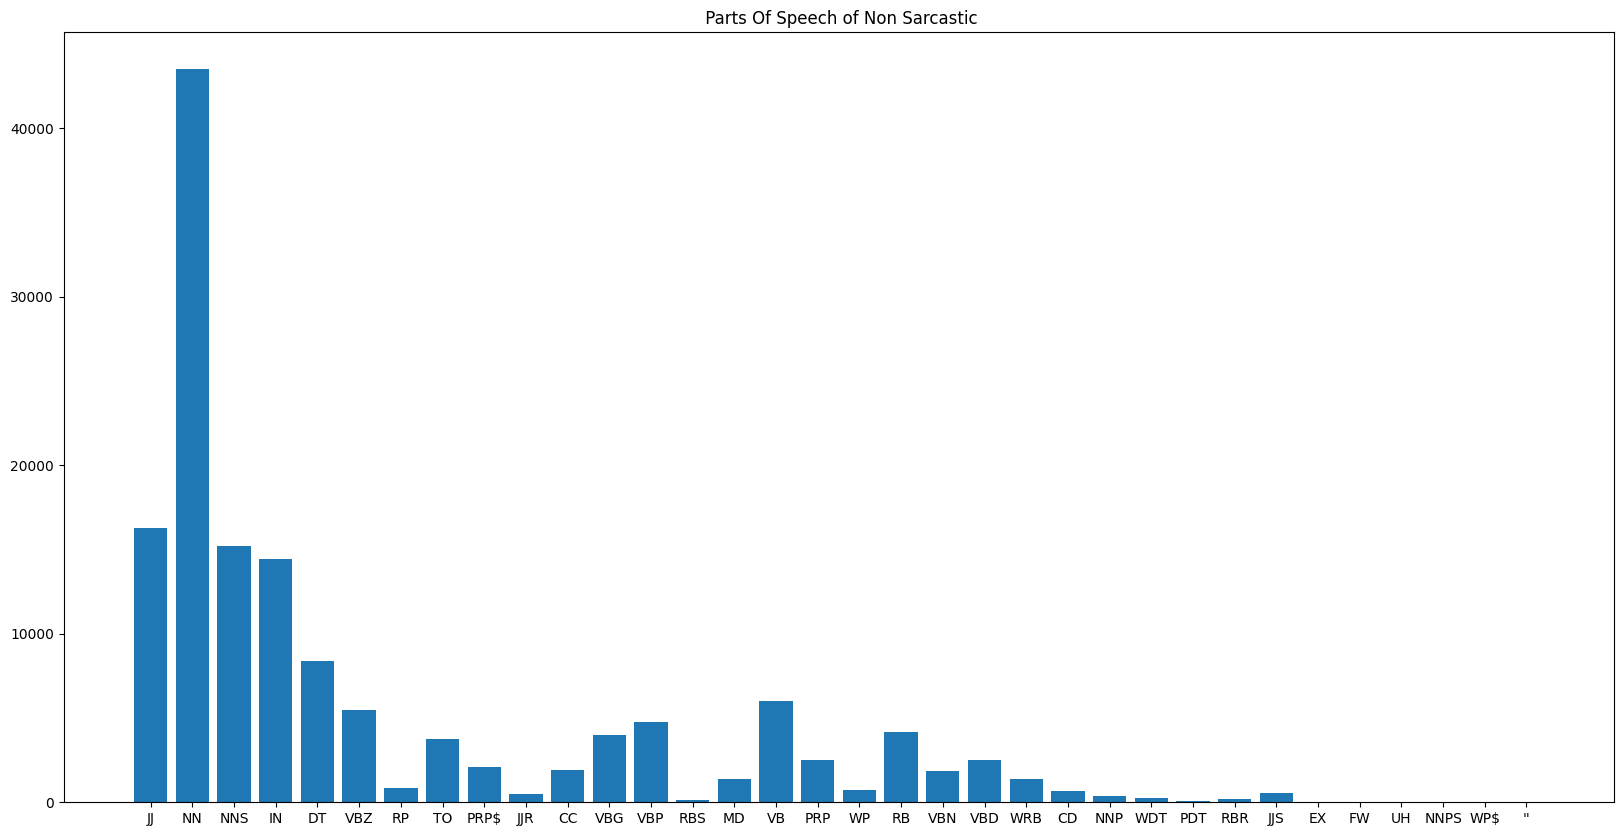

In [40]:
fig = plt.figure(figsize=(20,10))
plt.bar(*zip(*non_sarc_count.items()), align = 'center')
plt.title(" Parts Of Speech of Non Sarcastic")
plt.show()

In [41]:
lemm = WordNetLemmatizer()


def lemmat(x):
  try:
    x = x.split(" ")
    temp = []
    for i in x:
      temp.append(lemm.lemmatize(i))
    return temp
  except:
    return ["could not perform op"]

data_sar["lemmatizer"] = data_sar["clean_hd"].apply(lemmat)

<ipython-input-41-ed23cc85267b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sar["lemmatizer"] = data_sar["clean_hd"].apply(lemmat)


In [42]:
data_sar.head()

,headline,is_sarcastic,len,clean_hd,tokens,pos,lemmatizer
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild,"[mom, starting, to, fear, sons, web, series, closest, thing, she, will, have, to, grandchild]","[(mom, NN), (starting, VBG), (to, TO), (fear, VB), (sons, NNS), (web, JJ), (series, NN), (closest, JJS), (thing, NN), (she, PRP), (will, MD), (have, VB), (to, TO), (grandchild, VB)]","[mom, starting, to, fear, son, web, series, closest, thing, she, will, have, to, grandchild]"
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas,"[boehner, just, wants, wife, to, listen, not, come, up, with, alternative, debtreduction, ideas]","[(boehner, NN), (just, RB), (wants, VBZ), (wife, NN), (to, TO), (listen, VB), (not, RB), (come, VBN), (up, RP), (with, IN), (alternative, JJ), (debtreduction, NN), (ideas, NNS)]","[boehner, just, want, wife, to, listen, not, come, up, with, alternative, debtreduction, idea]"
8,top snake handler leaves sinking huckabee campaign,1,7,top snake handler leaves sinking huckabee campaign,"[top, snake, handler, leaves, sinking, huckabee, campaign]","[(top, JJ), (snake, NN), (handler, NN), (leaves, VBZ), (sinking, VBG), (huckabee, NN), (campaign, NN)]","[top, snake, handler, leaf, sinking, huckabee, campaign]"
15,nuclear bomb detonates during rehearsal for 'spider-man' musical,1,8,nuclear bomb detonates during rehearsal for spiderman musical,"[nuclear, bomb, detonates, during, rehearsal, for, spiderman, musical]","[(nuclear, JJ), (bomb, NN), (detonates, NNS), (during, IN), (rehearsal, NN), (for, IN), (spiderman, JJ), (musical, JJ)]","[nuclear, bomb, detonates, during, rehearsal, for, spiderman, musical]"
16,cosby lawyer asks why accusers didn't come forward to be smeared by legal team years ago,1,16,cosby lawyer asks why accusers didnt come forward to be smeared by legal team years ago,"[cosby, lawyer, asks, why, accusers, didnt, come, forward, to, be, smeared, by, legal, team, years, ago]","[(cosby, NN), (lawyer, NN), (asks, VBZ), (why, WRB), (accusers, NNS), (didnt, VBP), (come, VB), (forward, NN), (to, TO), (be, VB), (smeared, VBN), (by, IN), (legal, JJ), (team, NN), (years, NNS), (ago, RB)]","[cosby, lawyer, asks, why, accuser, didnt, come, forward, to, be, smeared, by, legal, team, year, ago]"


In [43]:
data['headline_new'] = data['headline'].apply(lambda x: re.sub('[^a-zA-Z]','  ',x))

In [44]:
noise_list = nltk.corpus.stopwords.words('english')

In [45]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i for i in x.split() if i not in noise_list])

In [46]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [47]:
data['headline_new'] = data['headline_new'].apply(lambda x: [lem.lemmatize(i,'v') for i in x])

In [48]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i.lower() for i in x])

In [49]:
#creating a frame with lemmatized and stopped sentences
#lambda to make lemmatized headlines

def join_lammatize(x):
  return " ".join(x)

data["lemmat"] = data["headline_new"].apply(join_lammatize)

import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

#stopper lambda:

def stopper_lambda(x):

  words = x.split(" ")
  temp = []
  for word in words:
    if word not in stops:
      temp.append(word)
  return " ".join(temp)


data["stopped"] = data["clean_hd"].apply(stopper_lambda)

In [50]:
#explaination of columns containing training data:

#headline : raw data
#clean_hd : removed punctuations
#lemmat: lemmatized sentences
#stopped : Removed stopwords
data.head()

,headline,is_sarcastic,len,clean_hd,tokens,headline_new,lemmat,stopped
0,former versace store clerk sues over secret 'black code' for minority shoppers,0,12,former versace store clerk sues over secret black code for minority shoppers,"[former, versace, store, clerk, sues, over, secret, black, code, for, minority, shoppers]","[former, versace, store, clerk, sue, secret, black, code, minority, shoppers]",former versace store clerk sue secret black code minority shoppers,former versace store clerk sues secret black code minority shoppers
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0,14,the roseanne revival catches up to our thorny political mood for better and worse,"[the, roseanne, revival, catches, up, to, our, thorny, political, mood, for, better, and, worse]","[roseanne, revival, catch, thorny, political, mood, better, worse]",roseanne revival catch thorny political mood better worse,roseanne revival catches thorny political mood better worse
2,mom starting to fear son's web series closest thing she will have to grandchild,1,14,mom starting to fear sons web series closest thing she will have to grandchild,"[mom, starting, to, fear, sons, web, series, closest, thing, she, will, have, to, grandchild]","[mom, start, fear, son, web, series, closest, thing, grandchild]",mom start fear son web series closest thing grandchild,mom starting fear sons web series closest thing grandchild
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1,13,boehner just wants wife to listen not come up with alternative debtreduction ideas,"[boehner, just, wants, wife, to, listen, not, come, up, with, alternative, debtreduction, ideas]","[boehner, want, wife, listen, come, alternative, debt, reduction, ideas]",boehner want wife listen come alternative debt reduction ideas,boehner wants wife listen come alternative debtreduction ideas
4,j.k. rowling wishes snape happy birthday in the most magical way,0,11,jk rowling wishes snape happy birthday in the most magical way,"[jk, rowling, wishes, snape, happy, birthday, in, the, most, magical, way]","[j, k, rowling, wish, snape, happy, birthday, magical, way]",j k rowling wish snape happy birthday magical way,jk rowling wishes snape happy birthday magical way


Generating embeddings using GLOVE

In [53]:
#loading word vectors
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
embeddings_index = {}
with open("/content/drive/My Drive/glove.6B.200d.txt") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
print(" Found %s words of vectors" % len(embeddings_index))

 Found 400000 words of vectors


Checking the shape of training data

In [54]:
Y = pd.get_dummies(data['is_sarcastic']).values
print(Y.shape)

X_train, Y_train, X_test, Y_test = train_test_split(data, Y, test_size = 0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(26606, 2)
(21284, 8) (5322, 8)
(21284, 2) (5322, 2)


Extracting unique tokens from the cleaned dataset and converting and padding sequences to make every sentence similar in length

In [55]:
corpus_selection = "headline" # it can be stopped, headline,lemmat also according to what corpus you want to train on

In [56]:
#based on selection of dataset comment and uncomment

# texts = data["lemmat"]  # lemmatized data
texts = data[corpus_selection] #simple data
# texts = data["headline"] #with punctuation
#texts = data["stopped"] #without stop words

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 29549 unique tokens.


In [57]:
clean_hd = 27539
lemmat = 20057
stopped = 27404
headline = 29549

plot_unique_dict = {"without punctuation":27539, "Lemmatized": 20057, "Stopped" : 27404 , "Raw data": 29549}

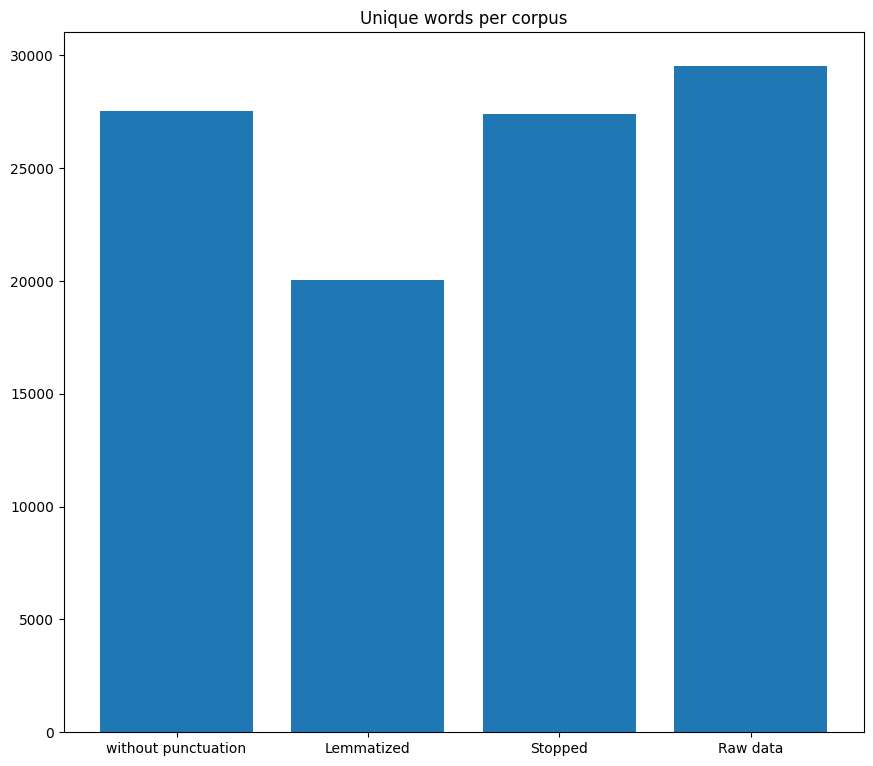

In [58]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))

ax1.set_title("Unique words per corpus")
plt.bar(range(len(plot_unique_dict)), list(plot_unique_dict.values()), align='center')
plt.xticks(range(len(plot_unique_dict)), list(plot_unique_dict.keys()))
plt.show()

Generating the sequence of the vectors

In [59]:
seq

array([[    0,     0,     0, ...,     5,  2564,  8387],
       [    0,     0,     0, ...,   262,     8,  1014],
       [    0,     0,     0, ...,    45,     1, 10688],
       ...,
       [    0,     0,     0, ..., 10687,     8,    65],
       [    0,     0,     0, ...,  1717,  3779,  3540],
       [    0,     0,     0, ...,     3, 29549,   819]], dtype=int32)

In [60]:
from sklearn.model_selection  import train_test_split
from keras.callbacks import LearningRateScheduler
from keras.layers import Input,Dense,Dropout,GlobalMaxPooling1D
import keras
from keras.models import Model

We create the embedding matrix which consists of unique tokens and vectors generated by Glove.

In [61]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


print(embedding_matrix.shape)

(29550, 200)


### Training the model by spliting the data into test(20%) and train(80%)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(seq, data["is_sarcastic"], test_size=0.20, random_state=42)

In [63]:
from keras.callbacks import Callback

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();

plot = PlotLearning

### Training the model by spliting the data into test(20%) and train(80%)

In [65]:
#adding a custom learning rate decay function
def step_decay(epoch):
    initial_lrate = 0.05
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return 0.0005**epoch

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


lr = LearningRateScheduler(step_decay, verbose=1)


embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling



Training model.


LSTM/RNN

In [66]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

embedded_sequences = keras.layers.SpatialDropout1D(0.3)(embedded_sequences)
x = LSTM(200,return_sequences=False)(embedded_sequences)
# x = Conv1D(200, 5, activation='relu')(x)
# x = Dense(1024,activation = "relu")(x)
# x = Dropout(0.2)(x)
x = Dense(512,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32,activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])



In [67]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 200)          5910000   
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 200)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

Epoch 1/10
666/666 [==============================] - ETA: 0s - loss: 0.6534 - acc: 0.6114

<Figure size 640x480 with 0 Axes>

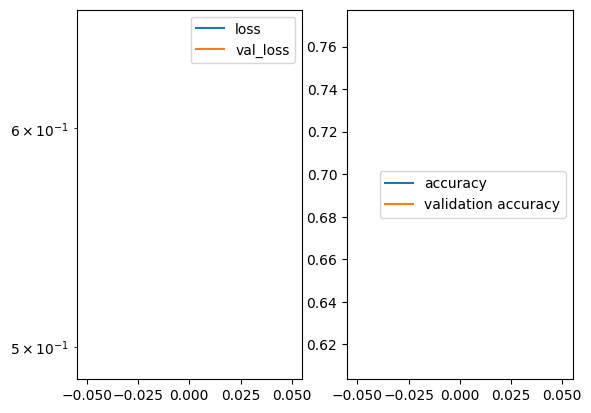

666/666 [==============================] - 320s 472ms/step - loss: 0.6534 - acc: 0.6114 - val_loss: 0.4934 - val_acc: 0.7694
Epoch 2/10
666/666 [==============================] - ETA: 0s - loss: 0.5233 - acc: 0.7432

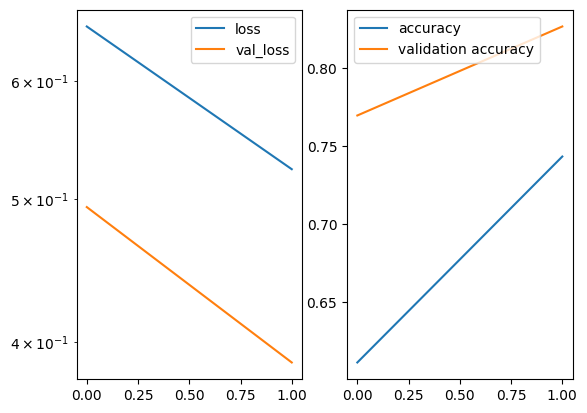

666/666 [==============================] - 308s 462ms/step - loss: 0.5233 - acc: 0.7432 - val_loss: 0.3875 - val_acc: 0.8264
Epoch 3/10
666/666 [==============================] - ETA: 0s - loss: 0.3956 - acc: 0.8276

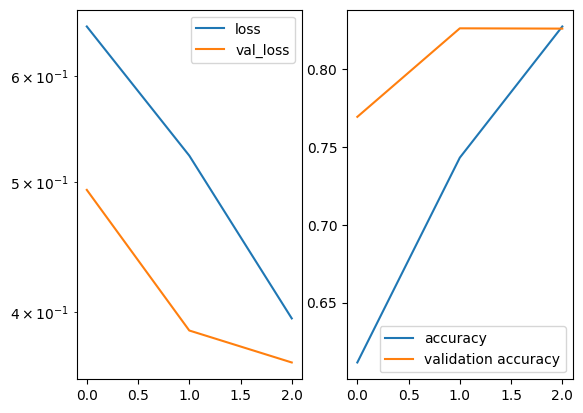

666/666 [==============================] - 297s 446ms/step - loss: 0.3956 - acc: 0.8276 - val_loss: 0.3668 - val_acc: 0.8262
Epoch 4/10
666/666 [==============================] - ETA: 0s - loss: 0.3484 - acc: 0.8486

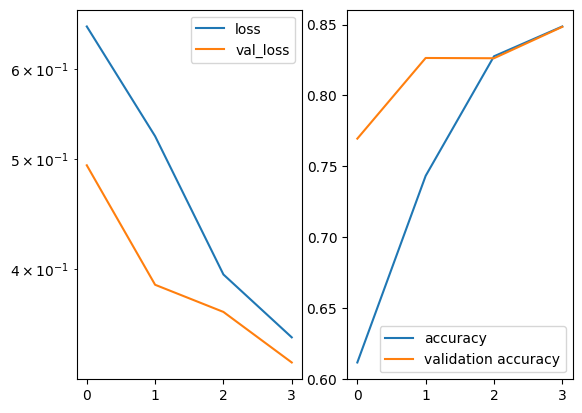

666/666 [==============================] - 315s 473ms/step - loss: 0.3484 - acc: 0.8486 - val_loss: 0.3311 - val_acc: 0.8484
Epoch 5/10
666/666 [==============================] - ETA: 0s - loss: 0.3151 - acc: 0.8670

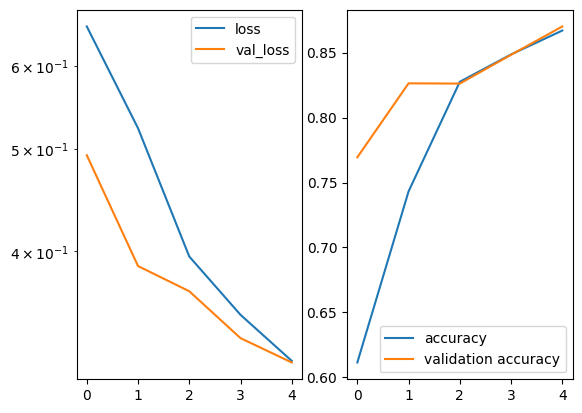

666/666 [==============================] - 313s 470ms/step - loss: 0.3151 - acc: 0.8670 - val_loss: 0.3140 - val_acc: 0.8702
Epoch 6/10
666/666 [==============================] - ETA: 0s - loss: 0.2825 - acc: 0.8830

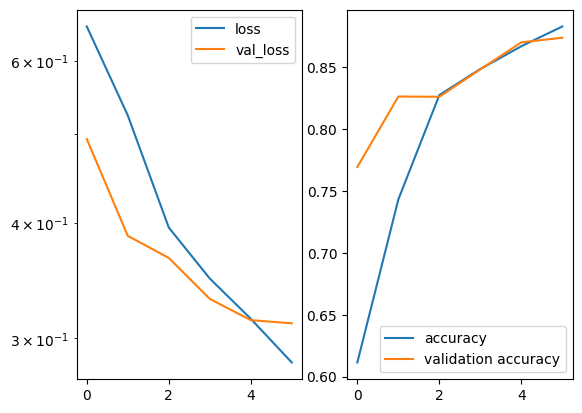

666/666 [==============================] - 315s 473ms/step - loss: 0.2825 - acc: 0.8830 - val_loss: 0.3115 - val_acc: 0.8739
Epoch 7/10
666/666 [==============================] - ETA: 0s - loss: 0.2576 - acc: 0.8955

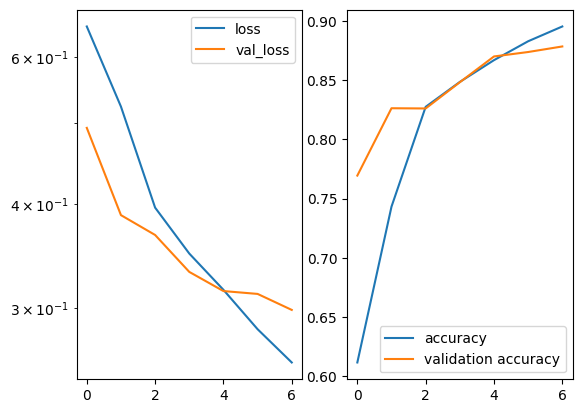

666/666 [==============================] - 311s 468ms/step - loss: 0.2576 - acc: 0.8955 - val_loss: 0.2980 - val_acc: 0.8786
Epoch 8/10
666/666 [==============================] - ETA: 0s - loss: 0.2306 - acc: 0.9048

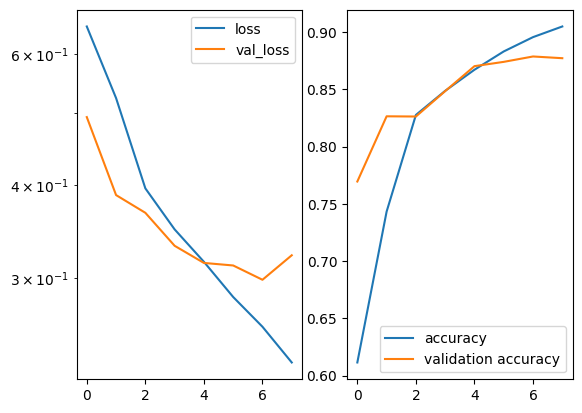

666/666 [==============================] - 314s 472ms/step - loss: 0.2306 - acc: 0.9048 - val_loss: 0.3215 - val_acc: 0.8771
Epoch 9/10
666/666 [==============================] - ETA: 0s - loss: 0.2043 - acc: 0.9158

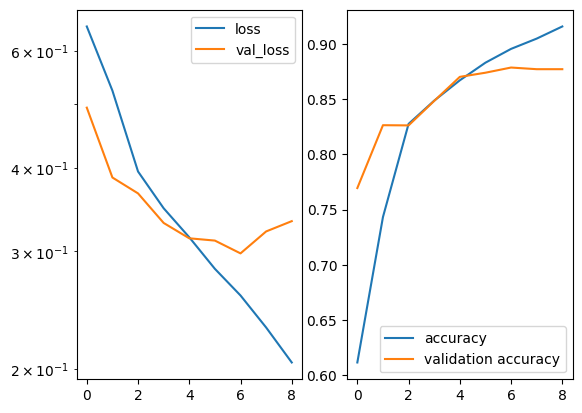

666/666 [==============================] - 314s 472ms/step - loss: 0.2043 - acc: 0.9158 - val_loss: 0.3332 - val_acc: 0.8771
Epoch 10/10
666/666 [==============================] - ETA: 0s - loss: 0.1918 - acc: 0.9231

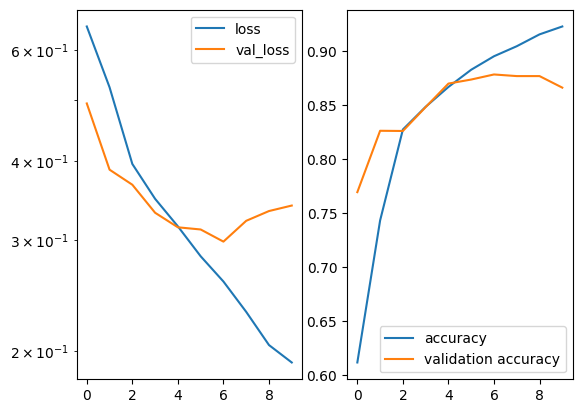

666/666 [==============================] - 314s 471ms/step - loss: 0.1918 - acc: 0.9231 - val_loss: 0.3399 - val_acc: 0.8664


In [68]:
history=model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
            validation_data=(X_test, y_test),callbacks=[PlotLearning()])

In [69]:
rnn_score = model.evaluate(X_test,y_test)

167/167 [==============================] - 30s 178ms/step - loss: 0.3399 - acc: 0.8664


In [70]:
rnn_score

[0.33993780612945557, 0.8664035797119141]

##Naive  Bayes Classifier

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics


In [72]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[corpus_selection],data['is_sarcastic'],random_state=33)

#Train and evaluate the model
vect = CountVectorizer().fit(X_train)
#vectorize sentences
X_train_vectorized = vect.transform(X_train)

#create and fit a multinomial naive bayes
clfrNB = MultinomialNB(alpha = 0.5)


clfrNB.fit(X_train_vectorized, y_train)


preds = clfrNB.predict(vect.transform(X_test))

naive_score = clfrNB.score(vect.transform(X_test),y_test)

score = roc_auc_score(y_test, preds)
print(metrics.classification_report(y_test,preds))
print(score)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3778
           1       0.83      0.80      0.82      2874

    accuracy                           0.84      6652
   macro avg       0.84      0.84      0.84      6652
weighted avg       0.84      0.84      0.84      6652

0.8383265309580832


Naive Bayes Classifier gives the accuracy of 84%

##Random Forest Classifier

In [74]:
rfc =  RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
rfc.fit(X_train_vectorized,y_train)
preds = rfc.predict(vect.transform(X_test))

In [75]:
print(metrics.classification_report(y_test,preds))
random_fo_score = rfc.score(vect.transform(X_test),y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.57      1.00      0.72      3778
           1       0.00      0.00      0.00      2874

    accuracy                           0.57      6652
   macro avg       0.28      0.50      0.36      6652
weighted avg       0.32      0.57      0.41      6652



## Linear Support Vector Classifier

In [89]:
svc_l1 = LinearSVC(dual= False)
svc_l2 = LinearSVC(penalty="l1",dual=False)

In [90]:
svc_l1.fit(X_train_vectorized,y_train)

LinearSVC(dual=False)

In [91]:
svc_l2.fit(X_train_vectorized,y_train)

LinearSVC(dual=False, penalty='l1')

In [92]:
svc_l1_score = svc_l1.score(vect.transform(X_test),y_test)

In [93]:
svc_l2_score = svc_l2.score(vect.transform(X_test),y_test)

With linear support vector classifier we get accuracy score of 82%

##Logistic Regression

In [81]:
lgr = LogisticRegression(random_state=0)

In [84]:
lgr.fit(X_train_vectorized,y_train)
y_pred = lgr.predict(vect.transform(X_test))


logistic_score = lgr.score(vect.transform(X_test),y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3778
           1       0.83      0.81      0.82      2874

    accuracy                           0.84      6652
   macro avg       0.84      0.84      0.84      6652
weighted avg       0.84      0.84      0.84      6652



With logistic regression we are able to classify the labels with 85% accuracy

##Evaluation of models

In [85]:
result_dict = {"Logistic regression":logistic_score,"Linear SVC with L1":svc_l1_score,"Linear SVC with L2":svc_l2_score,"Multinomial NB":naive_score,
                  "Random Forest":random_fo_score,"RNN":rnn_score[1]}

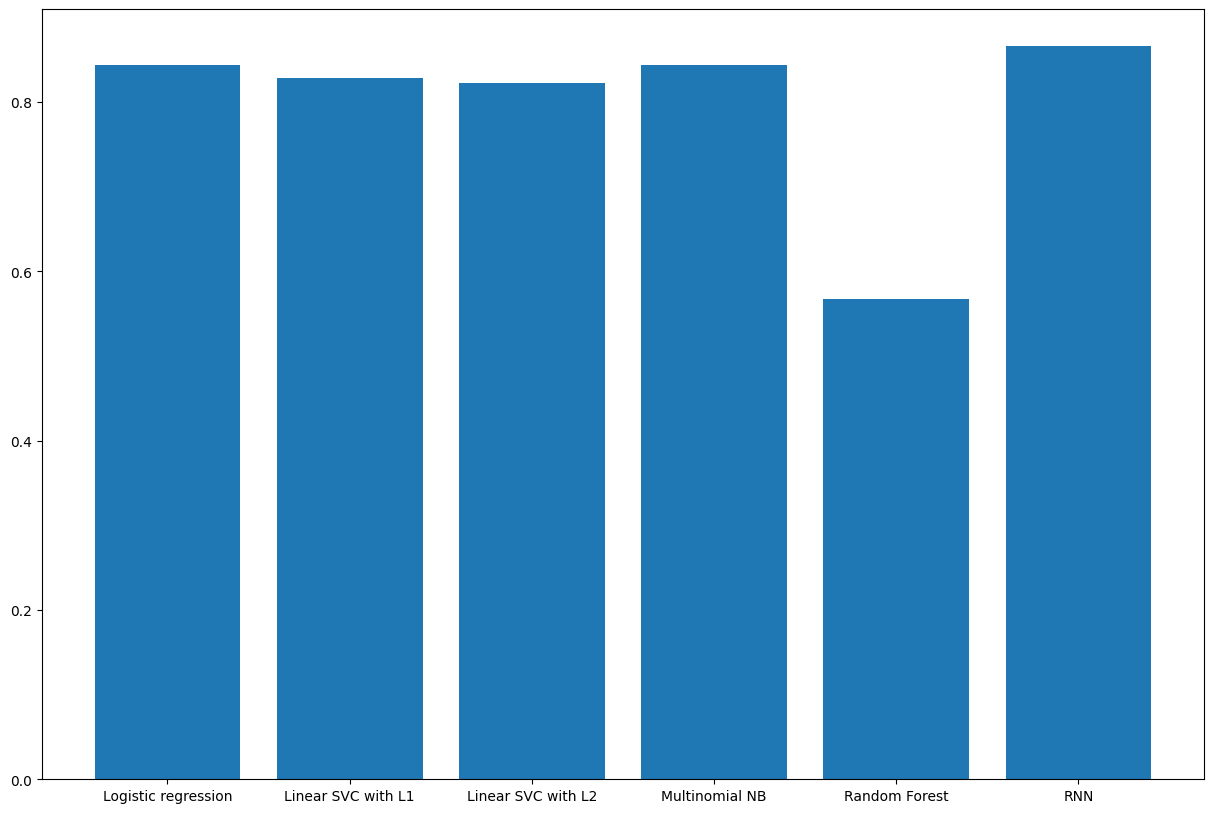

In [86]:
fig = plt.figure(figsize=(15,10))

plt.bar(range(len(result_dict)), list(result_dict.values()), align='center')
plt.xticks(range(len(result_dict)), list(result_dict.keys()))
plt.show()